# Laboratorio 2 - Perceptrón para clasificar lirios - Práctica 3

Grupo B07

- Álvaro Ramos Morales

- Álvaro Delgado Gallego

- Fernando Ramírez Fernández

- Juan Esteban Bernal Santos

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.python.client import device_lib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from keras.optimizers import Adam
from keras.callbacks import Callback


In [2]:
# Verifica si TensorFlow tiene acceso a la GPU
print("GPUs disponibles: ", tf.config.experimental.list_physical_devices('GPU'))

# Configura TensorFlow para que use la GPU si está disponible
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Establece la memoria de la GPU para que se asigne a demanda y no toda de una vez (opcional)
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Un error de tiempo de ejecución aquí significa que ya se han creado los objetos del programa
    print(e)

#leer datos
data = pd.read_csv('infarto.csv', delimiter=';', na_values='N/A')
data = data.dropna()
data = data.drop(columns=['id'])
#quitamos el nsnc
data = data[data.uso_tabaco != 'NSNC']

data.head(5)

GPUs disponibles:  []


,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,Masculino,67.0,0,1,Si,Privado,Urbana,228.69,36.6,Ex fumador,1
2,Masculino,80.0,0,1,Si,Privado,Rural,105.92,32.5,Nunca,1
3,Femenino,49.0,0,0,Si,Privado,Urbana,171.23,34.4,Fumador,1
4,Femenino,79.0,1,0,Si,Autonomo,Rural,174.12,24.0,Nunca,1
5,Masculino,81.0,0,0,Si,Privado,Urbana,186.21,29.0,Ex fumador,1


PREPROCESAMIENTO

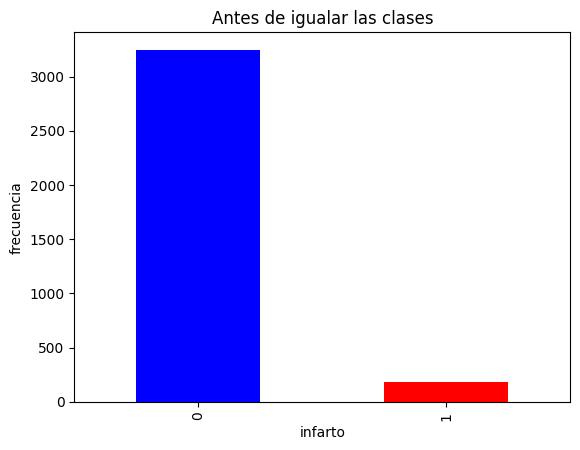

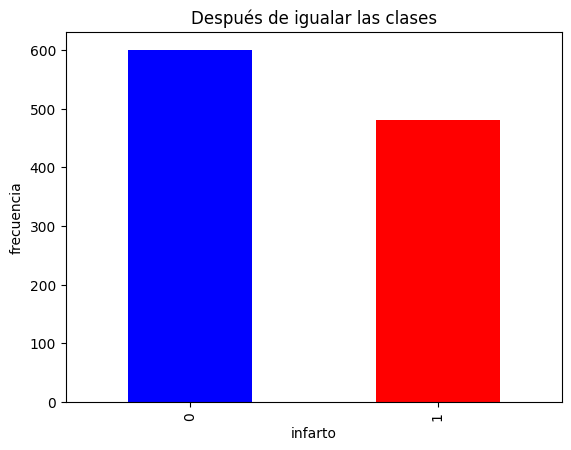

In [3]:
#HISTOGRAMA PARA VER LA DIFERENCIA DE CLASES 
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.title('Antes de igualar las clases')
plt.show()

#igualar la cantidad de datos de cada clase
rus = RandomUnderSampler(random_state=2, sampling_strategy=0.3)
data = data.dropna()
X = data.drop(columns=['infarto'])
y = data['infarto']
X_resampled, y_resampled = rus.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)

ros = RandomOverSampler(random_state=2, sampling_strategy=0.8)
X = data.drop(columns=['infarto'])
y = data['infarto']
X_resampled, y_resampled = ros.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)


#mostar el histograma para ver la diferencia de clases
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.title('Después de igualar las clases')
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.show()



Convertir a numerica las categoricas, usamos labelencoder para las varibles binarias y onehotencoder para las multi variable.

In [4]:
# Instanciar el codificador para cada columna categórica
enc = OneHotEncoder()
label_enc = LabelEncoder()

# Codificar las columnas categóricas binarias
data['genero'] = label_enc.fit_transform(data['genero'])
data['casado'] = label_enc.fit_transform(data['casado'])
data['residencia'] = label_enc.fit_transform(data['residencia'])

# Selección de las columnas para la codificación
multi_categorical_columns = ['uso_tabaco', 'trabajo']


# Ajustar el encoder y transformar los datos
multi_categorical_encoded = enc.fit_transform(data[multi_categorical_columns])

multi_categorical_encoded_df = pd.DataFrame(multi_categorical_encoded.toarray(), columns=enc.get_feature_names_out(multi_categorical_columns))

# Resetear índices si se modificó 'data'
data.reset_index(drop=True, inplace=True)
multi_categorical_encoded_df.reset_index(drop=True, inplace=True)

# Concatenar los DataFrames
data = pd.concat([data.drop(multi_categorical_columns, axis=1), multi_categorical_encoded_df], axis=1)

# Normalizar todas las columnas con min-max
for column in data.columns:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())






data.head(5)

,genero,edad,hipertensión,enfermedad_coronaria,casado,residencia,nivel_glucosa,bmi,infarto,uso_tabaco_Ex fumador,uso_tabaco_Fumador,uso_tabaco_Nunca,trabajo_Autonomo,trabajo_Funcionario,trabajo_Menor de edad,trabajo_Privado,trabajo_Sin trabajo
0,0.0,0.458333,0.0,0.0,1.0,1.0,0.197625,0.108818,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.652778,0.0,0.0,1.0,1.0,0.257647,0.307692,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.277778,0.0,0.0,0.0,1.0,0.154006,0.200750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.583333,0.0,0.0,1.0,1.0,0.224933,0.264540,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.666667,0.0,0.0,1.0,1.0,0.188938,0.225141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# Dividir los datos en características y etiqueta
X = data.drop('infarto', axis=1)
y = data['infarto']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#divir el train en train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)





Creamos el modelo

In [6]:



class MLPClassifier:
    def __init__(self, input_dim, nl=1, nn=1, activation='relu', optimizer='adam', loss='mean_squared_error', learning_rate=0.01):
        self.input_dim = input_dim
        self.nl = nl  # Número de capas ocultas
        self.nn = nn  # Número de neuronas en cada capa oculta
        self.activation = activation
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate

    def create_model(self):
        model = Sequential()
        # Agregar la capa de entrada
        model.add(Dense(self.nn, input_dim=self.input_dim, activation=self.activation))
        
        # Agregar capas ocultas según el número especificado en nl
        for _ in range(self.nl - 1):  # nl incluye todas las capas ocultas
            model.add(Dense(self.nn, activation=self.activation))
        
        self.optimizer = Adam(learning_rate=self.learning_rate)
        
        # Agregar la capa de salida
        model.add(Dense(1, activation='sigmoid'))  # Usualmente para problemas de clasificación binaria usamos 'sigmoid'

        # Compilar el modelo
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        return model
    


In [7]:
def build_keras_classifier(input_dim):
    def model(nl=1, nn=1,learning_rate=0.01):
        mlp = MLPClassifier(input_dim=input_dim, nl=nl, nn=nn)
        learning_rate = learning_rate
        return mlp.create_model()
    return model
    
# Asegúrate de que `X_train` está definido y accesible en este contexto.
input_dim = X_train.shape[1]  

keras_model = KerasClassifier(
    model=build_keras_classifier(input_dim),
    epochs=100,
    learning_rate=0.01
)

In [8]:

param_grid = {
    'model__nl': [2, 5, 10],  # Número de capas ocultas
    'model__nn': [128, 256, 512],  # Número de neuronas por capa oculta
    'learning_rate': [0.3,0.1,0.01,]
}

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Imprimir los resultados de la búsqueda en cuadrícula
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))


: 

Matriz de confusión

In [ ]:
# Obtener las predicciones del modelo con los mejores parámetros
y_pred = grid_result.best_estimator_.predict(X_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

y_train_pred = grid_result.best_estimator_.predict(X_train)
y_train_pred_binary = np.where(y_train_pred > 0.5, 1, 0)

# Calcular la matriz de confusión validacion
y_val_pred = grid_result.best_estimator_.predict(X_val)
y_val_pred_binary = np.where(y_val_pred > 0.5, 1, 0)

# Convertir y_test a un array de numpy
y_test_array = y_test.values
y_train_array = y_train.values
y_val_array = y_val.values

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_array, y_pred_binary)
print("Matriz de Confusión test:")
print(conf_matrix)

# Calcular la matriz de confusión
conf_matrix_train = confusion_matrix(y_train_array, y_train_pred_binary)
print("Matriz de Confusión train:")
print(conf_matrix_train)

conf_matrix_val = confusion_matrix(y_val_array, y_val_pred_binary)
print("Matriz de Confusión val:")
print(conf_matrix_val)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
Matriz de Confusión test:
[[102  23]
 [ 14  77]]
Matriz de Confusión train:
[[365   9]
 [ 31 286]]
Matriz de Confusión val:
[[86 15]
 [12 60]]


In [ ]:
#mostrar la tabla con la precisión, sensibilidad y especificidad del test y train
table = [['', 'Precision', 'Sensibilidad', 'Especificidad'],
                ['Test', accuracy_score(y_test_array, y_pred_binary), conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]), conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])],
                ['Train', accuracy_score(y_train_array, y_train_pred_binary), conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[0, 1]), conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[1, 0])],
                ['Val', accuracy_score(y_val_array, y_val_pred_binary), conf_matrix_val[1, 1] / (conf_matrix_val[1, 1] + conf_matrix_val[0, 1]), conf_matrix_val[0, 0] / (conf_matrix_val[0, 0] + conf_matrix_val[1, 0])]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))





╒═══════╤═════════════╤════════════════╤═════════════════╕
│       │   Precision │   Sensibilidad │   Especificidad │
╞═══════╪═════════════╪════════════════╪═════════════════╡
│ Test  │    0.828704 │       0.77     │        0.87931  │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Train │    0.942113 │       0.969492 │        0.921717 │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Val   │    0.843931 │       0.8      │        0.877551 │
╘═══════╧═════════════╧════════════════╧═════════════════╛


In [ ]:
#mostrar grafica de accuracy con epochs con una linea de train, test y val
history = MLPClassifier.train(X_train, y_train, X_test, y_test, epochs=100)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


TypeError: MLPClassifier.train() missing 1 required positional argument: 'y_val'